## **Forecasting Housing Price Trends in New Zealand Using Machine Learning**

#### Goal: Analyse historical housing market data to identify key economic drivers and forecast future housing price trends to support urban planning, investment strategies, and policy development in New Zealand.

Author: Haru

Date: 25 April 2025

#### **Introduction**

In this project, I analysed historical housing market data in New Zealand to uncover the main factors influencing the Housing Price Index (HPI), including total housing stock value and residential investment (GDP). Regional analysis showed significant differences across cities, with Auckland consistently leading in prices. Using a Random Forest model, I forecasted housing prices for 2025–2030, projecting moderate and stable growth. These insights aim to support strategic decision-making in urban planning and housing investments.

## **1. Data Collection**

Data Sources:
- Reserve Bank of New Zealand
- Stats NZ
- Figure NZ

In [7]:
!pip install pandas
import pandas as pd

**1-1. House price index (HPI) data from Stats NZ**

In [9]:
housing_price = pd.read_excel(r"C:\Users\pc\Downloads\hm10 (1).xlsx")

C:\Users\pc\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


**1-2. Population and migration data from Stats NZ**

In [11]:
population_data =pd.read_csv(r"C:\Users\pc\Downloads\components-of-new-zealand’s-population-change,-year-ended-december-1992–2024.csv")

**1-3. Household Income Data from Reserve Bank of New Zealand**

In [13]:
income_df = pd.read_csv(r"C:\Users\pc\Downloads\household-final-consumption-expenditure-and-net-disposable-income-($),-september-2017–september-2022-quarters.csv")

**1-4. Resional data from Figure NZ**

In [15]:
Resional_df = pd.read_csv(r"C:\Users\pc\Downloads\Property_Median_sale_price_for_houses_and_apartments_by_location_Jul_2018Jun_2019.csv")

### **2. Data Cleaning & Preprocessing**

#### 2-1. **Clean House Price Index Data:**

In [300]:
housing_price.head()

,Unnamed: 0,House sales,House price index (HPI),Total value of housing stock,Residential investment (GDP)
0,NaN,(Number),(Index),($m),(Real $m)
1,Notes,NaN,NaN,Yes,NaN
2,Unit,no,Index,NZDm,NZDm(r)
3,Series Id,QVB.Q.MR0H01.na,HPI.Q.H01T0.ia,HHAL.QC1,GDE.Q.EI24.RA
4,1990-03-31 00:00:00,22855,477,123000,1790


We need to do 
- Skip 4 metadata rows at the top
- Rename the columns for clarity
- Convert to an annual data to merge with other data(Convert date column to datetime)
- Remove null values and duplicate records 

(House sales data was excluded as transaction volumes are typically a lagging indicator of price movements and may introduce noise without directly improving predictive accuracy for housing price dynamics.)

In [27]:
#Skip 4 metadata rows at the top
housing_price_clean = pd.read_excel(r"C:\Users\pc\Downloads\hm10 (1).xlsx", skiprows=4)


#Rename the columns for clarity
housing_price_2 = housing_price_clean.copy()
housing_price_2 = housing_price_2.rename(columns={
    'Series Id': 'Date',
    'HPI.Q.H01T0.ia': 'Average HPI',
    'HHAL.QC1': 'Total value of housing stock',
    'GDE.Q.EI24.RA': 'Residential investment (GDP)'
})
housing_price_2 = housing_price_2.rename(columns={
    'HPI': 'Average HPI',
})

#Convert to an annual data to merge with other data(Convert date column to datetime)
housing_price_clean['Series Id'] =pd.to_datetime(housing_price_clean['Series Id'], errors ='coerce')

housing_price_2['Year'] = housing_price_2["Date"].dt.year
yearly_hip = housing_price_2.groupby('Year')['Average HPI'].mean().reset_index()
yearly_data = housing_price_2.groupby('Year').agg({
    'Average HPI': 'mean',
    'Total value of housing stock': 'mean',
    'Residential investment (GDP)': 'mean'
}).reset_index()

print(yearly_data.head())

   Year  Average HPI  Total value of housing stock  \
0  1990       480.50                      125000.0   
1  1991       470.75                      124250.0   
2  1992       470.50                      127250.0   
3  1993       489.25                      135000.0   
4  1994       545.50                      156500.0   

   Residential investment (GDP)  
0                       1922.75  
1                       1604.50  
2                       1633.00  
3                       1877.75  
4                       2146.50  


C:\Users\pc\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [28]:
#Remove null values and duplicate records
yearly_data.isnull().sum()

Year                            0
Average HPI                     0
Total value of housing stock    0
Residential investment (GDP)    0
dtype: int64

In [29]:
yearly_data.duplicated().sum()

0

#### **2-2. Population and migration data:**

In [303]:
population_data.head()

,Year,Natural increase,Net migration,Total population change
0,1992,31600,4600,36300
1,1993,31600,14000,45600
2,1994,30600,19900,50400
3,1995,30000,28500,58400
4,1996,29400,24800,55600


We need to do
- Remove null values and duplicate records

In [32]:
population_data.isnull().sum()

Year                       0
Natural increase           0
Net migration              0
Total population change    0
dtype: int64

In [33]:
population_data.duplicated().sum()

0

#### **2-3.Household Income Data**

In [305]:
income_df.head()

,Quarter,Final consumption expenditure,Net disposable income,Year
0,2017-09-01,40611000000,40184000000,2017
1,2017-12-01,41351000000,41577000000,2017
2,2018-03-01,41788000000,41874000000,2018
3,2018-06-01,42555000000,42710000000,2018
4,2018-09-01,43295000000,43800000000,2018


We need to do
- Convert to an annual data to merge with other data(Convert date column to datetime)
- Remove null values and duplicate records

In [36]:
income_df.isnull().sum()

Quarter                          0
Final consumption expenditure    0
Net disposable income            0
dtype: int64

In [37]:
income_df.duplicated().sum()

0

In [38]:
income_df.head()

,Quarter,Final consumption expenditure,Net disposable income
0,Sep-17,40611000000,40184000000
1,Dec-17,41351000000,41577000000
2,Mar-18,41788000000,41874000000
3,Jun-18,42555000000,42710000000
4,Sep-18,43295000000,43800000000


Convert date column to datetime.

In [39]:
income_df["Quarter"] = pd.to_datetime(income_df["Quarter"], format='%b-%y',  errors='coerce')
income_df.head()

,Quarter,Final consumption expenditure,Net disposable income
0,2017-09-01,40611000000,40184000000
1,2017-12-01,41351000000,41577000000
2,2018-03-01,41788000000,41874000000
3,2018-06-01,42555000000,42710000000
4,2018-09-01,43295000000,43800000000


Make a yearly data

In [40]:
income_df["Year"] = income_df["Quarter"].dt.year
annual_income = income_df.groupby("Year")[["Final consumption expenditure", "Net disposable income"]].sum().reset_index()
print(annual_income)

   Year  Final consumption expenditure  Net disposable income
0  2017                    81962000000            81761000000
1  2018                   171571000000           172394000000
2  2019                   179784000000           182980000000
3  2020                   179076000000           194829000000
4  2021                   198466000000           207497000000
5  2022                   160571000000           164522000000


#### **2-4.Resional data**

In [307]:
Resional_df.head()

,Month,Property type,Location,Measure,Value,Value Unit,Value Label,Null Reason
0,2018-07,House,Auckland,Median sale price,906500.0,nzd,NZD,NaN
1,2018-07,House,Christchurch,Median sale price,455000.0,nzd,NZD,NaN
2,2018-07,House,North Island Metro,Median sale price,530000.0,nzd,NZD,NaN
3,2018-07,House,Other,Median sale price,420000.0,nzd,NZD,NaN
4,2018-07,House,South Island Metro,Median sale price,353000.0,nzd,NZD,NaN


We nee to do
- Delete unnecessary columns
- Convert to an annual data to merge with other data
- Remove null values and duplicate records

Delete unnecessary columns and  make an annual data

In [43]:
#Delete unnecessary columns
Resional_selected = Resional_df[["Month", "Location", "Value"]]

#Convert to an annual data to merge with other data
Resional_selected["Year"]=Resional_selected["Month"].str[:4]
yearly_resion = Resional_selected.groupby(['Year', 'Location']).agg({'Value': 'mean'}).reset_index()

yearly_resion                                                                     

C:\Users\pc\AppData\Local\Temp\ipykernel_15128\808315766.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resional_selected["Year"]=Resional_selected["Month"].str[:4]


,Year,Location,Value
0,2018,Auckland,787081.250000
1,2018,Christchurch,406946.833333
2,2018,North Island Metro,492604.166667
3,2018,Other,381072.916667
4,2018,South Island Metro,333691.958333
5,2018,Wellington,575256.916667
6,2019,Auckland,766889.583333
7,2019,Christchurch,403387.000000
8,2019,North Island Metro,494796.666667
9,2019,Other,384693.750000


Pivot the data to make the table more user-friendly 

In [44]:
location_data = yearly_resion.pivot(index='Year', columns='Location', values='Value')
location_data

Location,Auckland,Christchurch,North Island Metro,Other,South Island Metro,Wellington
Year,,,,,,
2018,787081.250000,406946.833333,492604.166667,381072.916667,333691.958333,575256.916667
2019,766889.583333,403387.000000,494796.666667,384693.750000,357521.833333,588914.541667


*Obviously, no Null values amd no duplicated records*

#### **2-5. Merging the dataset(Except Resional data to avoid misleading)**

In [47]:
merged_df = yearly_data \
.merge(population_data, on="Year", how="left") \
.merge(annual_income, on="Year", how="left") 

merged_df.head()

,Year,Average HPI,Total value of housing stock,Residential investment (GDP),Natural increase,Net migration,Total population change,Final consumption expenditure,Net disposable income
0,1990,480.50,125000.0,1922.75,NaN,NaN,NaN,NaN,NaN
1,1991,470.75,124250.0,1604.50,NaN,NaN,NaN,NaN,NaN
2,1992,470.50,127250.0,1633.00,31600.0,4600.0,36300.0,NaN,NaN
3,1993,489.25,135000.0,1877.75,31600.0,14000.0,45600.0,NaN,NaN
4,1994,545.50,156500.0,2146.50,30600.0,19900.0,50400.0,NaN,NaN


#### **Storing DataFrame into SQLite**

In [49]:
!pip install sqlalchemy 
import sqlite3
conn = sqlite3.connect('housing_price.db')

merged_df.to_sql("merged_df_sql", conn, if_exists="replace", index=False)
pd.read_sql("SELECT * FROM merged_df_sql LIMIT 5", conn)

,Year,Average HPI,Total value of housing stock,Residential investment (GDP),Natural increase,Net migration,Total population change,Final consumption expenditure,Net disposable income
0,1990,480.50,125000.0,1922.75,NaN,NaN,NaN,None,None
1,1991,470.75,124250.0,1604.50,NaN,NaN,NaN,None,None
2,1992,470.50,127250.0,1633.00,31600.0,4600.0,36300.0,None,None
3,1993,489.25,135000.0,1877.75,31600.0,14000.0,45600.0,None,None
4,1994,545.50,156500.0,2146.50,30600.0,19900.0,50400.0,None,None


### **4. Exploratory Data Analysis (EDA)**

#### **4-1. Use Random Forest feature importance analysis to identify potential key predictors**

In [52]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

merged_df= merged_df.dropna()
X = merged_df[['Year', 'Total value of housing stock', 'Residential investment (GDP)', 'Natural increase', 'Net migration', 'Total population change', 'Final consumption expenditure', 'Net disposable income']]
y = merged_df['Average HPI']

model = RandomForestRegressor(
    n_estimators=100,  
    random_state=42,   
    max_depth=5        
)


model.fit(X, y)

model.fit(X, y)


feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)

                         Feature  Importance
2   Residential investment (GDP)    0.181102
4                  Net migration    0.177246
1   Total value of housing stock    0.167899
5        Total population change    0.156651
0                           Year    0.143212
3               Natural increase    0.073193
7          Net disposable income    0.059451
6  Final consumption expenditure    0.041245


*Visualize the feature importance with a bar chart for clarity.*

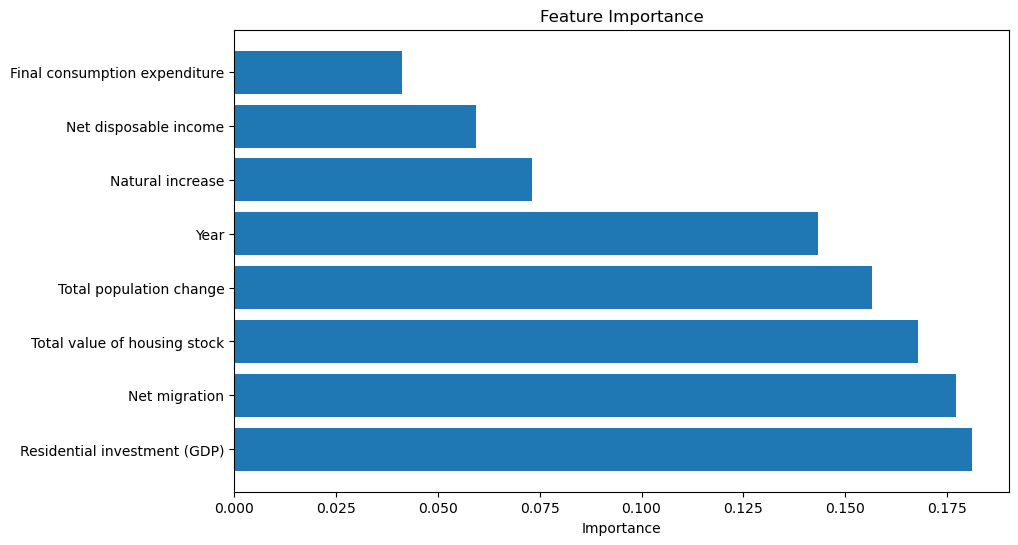

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

**We exclude 'Final consumption expenditure', 'Net disposable income', and 'Natural increase' from the merged dataset due to their limited data points and minimal impact on HPI, focusing instead on the five most influential features to create a more robust dataset.**

In [56]:
merged_df_nan = yearly_data \
.merge(population_data, on="Year", how="left") \
.merge(annual_income, on="Year", how="left") 
merged_df_nan.head()

,Year,Average HPI,Total value of housing stock,Residential investment (GDP),Natural increase,Net migration,Total population change,Final consumption expenditure,Net disposable income
0,1990,480.50,125000.0,1922.75,NaN,NaN,NaN,NaN,NaN
1,1991,470.75,124250.0,1604.50,NaN,NaN,NaN,NaN,NaN
2,1992,470.50,127250.0,1633.00,31600.0,4600.0,36300.0,NaN,NaN
3,1993,489.25,135000.0,1877.75,31600.0,14000.0,45600.0,NaN,NaN
4,1994,545.50,156500.0,2146.50,30600.0,19900.0,50400.0,NaN,NaN


We remove null values.

In [57]:
merged_df_5 = merged_df_nan[["Average HPI", "Residential investment (GDP)", "Net migration",\
               "Total value of housing stock","Total population change","Year"]]
merged_df_5
merged_df_5 = merged_df_5.dropna()
merged_df_5.head()

,Average HPI,Residential investment (GDP),Net migration,Total value of housing stock,Total population change,Year
2,470.50,1633.00,4600.0,127250.0,36300.0,1992
3,489.25,1877.75,14000.0,135000.0,45600.0,1993
4,545.50,2146.50,19900.0,156500.0,50400.0,1994
5,596.00,2201.00,28500.0,175000.0,58400.0,1995
6,664.50,2280.75,24800.0,196500.0,55600.0,1996


In [58]:
merged_df_5.shape

(33, 6)

**Now, we can focus on 5 toppest important features and increased data points from 6 to 33 that makes our analyse more accurate.**

#### **4-2. Converting the merged dataset and resional dataset to CSV format for Power BI analysis**

In [61]:
merged_df_5.to_csv("merged_df_5.csv", index=False)
yearly_resion.to_csv("yearly_resion.csv", index=False)

In [62]:
#Check the directory
import os
print(os.getcwd())

C:\Users\pc\Visualization and Forecasting of Housing Prices and Population Dynamics


#### **4-3. Analyzing Correlation coefficientt and Pvalu of the five most influential features**
We expanded the dataset to include additional data points that may alter the feature importance rankings.

In [64]:
from scipy.stats import pearsonr

- **Average HPI VS Residential investment (GDP)**

In [66]:
correlation, p_value = pearsonr(merged_df_5["Average HPI"], merged_df_5["Residential investment (GDP)"])
print(f"Correlation coefficient : {correlation: .3f}")
print(f"pvalue:{p_value: .5f}")

Correlation coefficient :  0.881
pvalue: 0.00000


*Strong positive relationship and Statistically significant*

- **Average HPI VS Net migration**

In [69]:
correlation, p_value = pearsonr(merged_df_5["Average HPI"], merged_df_5["Net migration"])
print(f"Correlation coefficient : {correlation: .3f}")
print(f"pvalue:{p_value: .5f}")

Correlation coefficient :  0.465
pvalue: 0.00636


*Moderate positive correlation and Statistically significant*

- **Average HPI VS Total value of housing stock**

In [72]:
correlation, p_value = pearsonr(merged_df_5["Average HPI"], merged_df_5["Total value of housing stock"])
print(f"Correlation coefficient : {correlation: .3f}")
print(f"pvalue:{p_value: .5f}")

Correlation coefficient :  0.999
pvalue: 0.00000


*Strong positive correlation and Highly significant (strong evidence against null hypothesis)*

- **Average HPI VS Total population change**

In [75]:
correlation, p_value = pearsonr(merged_df_5["Average HPI"], merged_df_5["Total population change"])
print(f"Correlation coefficient : {correlation: .3f}")
print(f"pvalue:{p_value: .5f}")

Correlation coefficient :  0.304
pvalue: 0.08569


*No meaningful correlation*

- **Average HPI VS Year**

In [78]:
correlation, p_value = pearsonr(merged_df_5["Average HPI"],merged_df_5["Year"])
print(f"Correlation coefficient : {correlation: .3f}")
print(f"pvalue:{p_value: .5f}")

Correlation coefficient :  0.949
pvalue: 0.00000


*Strong positive correlation and Highly significant*

**Based on the correlation coefficients and p-values, we observe significant changes in feature importance rankings. To visualize these shifts, we will generate a comparative bar graph.**

In [81]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

X1 = merged_df_5[['Residential investment (GDP)', 'Net migration', 'Total value of housing stock', 'Total population change', 'Year']]
y1 = merged_df_5['Average HPI']

model1 = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=5
)

model1.fit(X1,y1)

feature_importance1 = pd.DataFrame({
    'Feature': X1.columns,
    'Importance': model1.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance1)

                        Feature  Importance
4                          Year    0.429731
2  Total value of housing stock    0.338783
0  Residential investment (GDP)    0.216872
3       Total population change    0.008442
1                 Net migration    0.006172


In [377]:
feature_importance1.to_csv("feature_importance1.csv",index=False) 

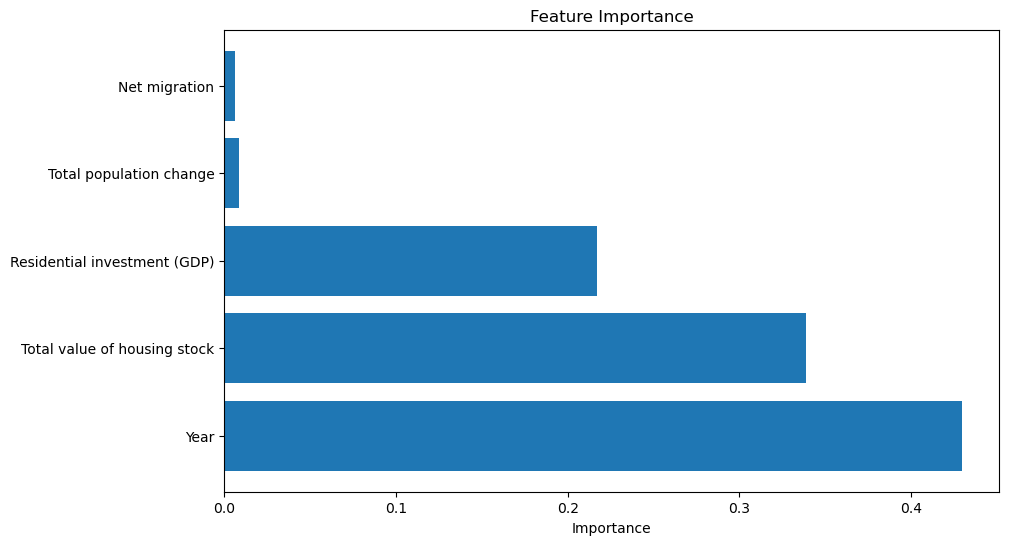

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance1['Feature'], feature_importance1['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

**Since insights from the feature importance bar chart, I analyzed the relationships between the top three influential features and HPI in Power BI. Additionally, I examined regional datasets to understand geographic variations in housing prices.**

(I incorporated the Power BI data into a dashboard.)

#### **4-4. Summerize of EDA**

- The bar chart indicates that Year has the strongest correlation with **HPI** (r = 0.949), followed by **Total value of housing stock** and **Residential investment (GDP)** as the second and third most influential features, respectively.
- **Housing prices (HPI)** exhibited sustained growth until 2021 but entered a decline thereafter, likely influenced by post-pandemic economic conditions such as rising interest rates and shifting housing demand patterns.
- **Residential investment (GDP)** also show strong positive correlation with HPI, indicating economic growth may drive demand.
- **Net migration(r = 0.465)** and **Total population changes(r = 0.304)** demonstrate weak-to-moderate correlations with HPI, suggesting limited predictive relevance for housing price dynamics in this dataset.
- As expected, **Total value of housing stock** demonstrates a stable positive relationship with HPI, confirming its reliability as a fundamental indicator of housing market health.
- The **Regional data** analysis reveals that housing prices in Auckland are consistently the highest, while South Island Metro areas (smaller urban centers in the South Island such as Dunedin and Nelson, excluding Christchurch) record the lowest prices.
- Between 2018 and 2019, housing prices showed an overall upward trend, while Auckland and Christchurch experienced marginal declines.

- **Unexpected Results: Population Change and HPI**: During the EDA, I expected a significant correlation between population change and net migration with the Housing Price Index (HPI). However, the analysis showed weak or no correlation between these variables and HPI.

**Possible reasons:**

- Supply-side factors: such as housing stock and residential investment, may have had a greater impact on HPI.

- Lag effects: Population changes may take years to impact housing prices.

- Regional variations: HPI trends might differ by region, especially in larger cities like Auckland.

## **5. Forecasting**

**I chose ARIMA, Random Forest and Liner Regression to compare.**

*Why I chose these three* :

I selected these three models to compare traditional statistical forecasting (ARIMA), machine learning (Random Forest), and simple trend modeling (Linear Regression). This combination allows me to evaluate performance across different modeling approaches—time series-based, non-linear, and linear—using the same dataset for housing price trends.

#### **5-1.Time Series Forecasting (ARIMA)**

In [217]:
#Make year-HPI dataset for ARIM.
yearly_df_ARIMA = merged_df_5[["Year", "Average HPI"]]
yearly_df_ARIMA.head()

,Year,Average HPI
2,1992,470.50
3,1993,489.25
4,1994,545.50
5,1995,596.00
6,1996,664.50


In [209]:
print(yearly_df_ARIMA.columns.tolist())

['Year', 'Average HPI']


Predict HPI using AMIRA

In [213]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


model_ARIMA = ARIMA(yearly_df_ARIMA['Average HPI'], order=(1, 1, 1))
model_fit_ARIMA = model_ARIMA.fit()


forecast_ARIMA = model_fit_ARIMA.forecast(steps=6)


forecast_years = list(range(yearly_data_ARIMA.index[-1] + 1, yearly_data_ARIMA.index[-1] + 7))


forecast_ARIMA = pd.DataFrame({
    'Year': forecast_years,
    'Predicted Average HPI': forecast_ARIMA
})

print(forecast_ARIMA)


    Year  Predicted Average HPI
33  2025            3418.720876
34  2026            3418.607450
35  2027            3418.609605
36  2028            3418.609564
37  2029            3418.609565
38  2030            3418.609565


C:\Users\pc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\pc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

ARIMA Model Forecast Results:

The results show that the forecasted values from 2025 to 2030 remain almost constant at approximately 3418.61. This suggests that the model predicts a stable trend in the future. Despite the past data (from 1992 to 2024) showing a steady increase in HPI, the ARIMA model was not able to capture the sharp rise in recent years, which might explain the constant forecasted values.

These results indicate a stable forecast, assuming no major fluctuations in HPI in the future. However, given the recent rapid increase in HPI, future model improvements such as using Random Forest or Prophet may allow for more accurate predictions that account for potential fluctuations and trends.

**Analyzing Coefficient of determination and Mean Absolute Error of the AMIRA model**

In [148]:
import pandas as ps 
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, r2_score

y_ARIMA=yearly_data['Average HPI']
#Split into train and test (e.g., 80% train, 20% test)
train_size = int(len(y) *0.8)
y_ARIMA_train =y_ARIMA[:train_size]   #Slice
y_ARIMA_test = y_ARIMA[train_size:]

# Fit ARIMA model on training data
model_ARIMA = ARIMA(y_ARIMA_train, order=(1, 1, 1))
model_fit_ARIMA = model_ARIMA.fit()
#  Forecast for the test set period
forecast_ARIMA = model_fit_ARIMA.forecast(steps=len(y2_test))

# Evaluate the model
mae_ARIMA = mean_absolute_error(y_ARIMA_test, forecast)
r2_ARIMA = r2_score(y_ARIMA_test, forecast_ARIMA)

print(f"MAE: {mae_ARIMA:.2f}")
print(f"R² Score:{r2_ARIMA:.4f}")

C:\Users\pc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pc\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\pc\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No suppor

MAE: 1099.11
R² Score:-1.3751


These scores indicate the model has severe issues, let's try other method.

#### **5-2. Machine Learning (Random Forest)**

In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [150]:
X_rf = merged_df_5[['Year', 'Total value of housing stock', 'Residential investment (GDP)']]
y_rf = merged_df_5['Average HPI']

X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_rf_train, y_rf_train)

y_rf_pred = model_rf.predict(X_rf_test)


**Analyzing Coefficient of determination and Mean Absolute Error of the Random Forest model**

In [154]:

r2_rf = r2_score(y_rf_test, y_rf_pred)
mae_rf = mean_absolute_error(y_rf_test, y_rf_pred)

print("R²:", r2_rf)
print("MAE:", mae_rf)

R²: 0.997026299638823
MAE: 34.6307142857143


Conveting to csv

In [372]:
r2_score_data = {'Metric': ['R² Score'], 'Value': [r2]}
df = pd.DataFrame(r2_score_data)
df.to_csv('r2_score.csv', index=False)

The model is highly accurate but should be checked for overfitting

In [384]:
print(f"Train R²: {model_rf.score(X_rf_train, y_rf_train):.3f}")  # Likely ~0.997
print(f"Test R²:  {model_rf.score(X_rf_test, y_rf_test):.3f}")    # If <<0.997 → Overfitting

Train R²: 0.997
Test R²:  0.997


The model does not seem to be overfitting.

**Comparing Predicted and Actual HPII**

10 10


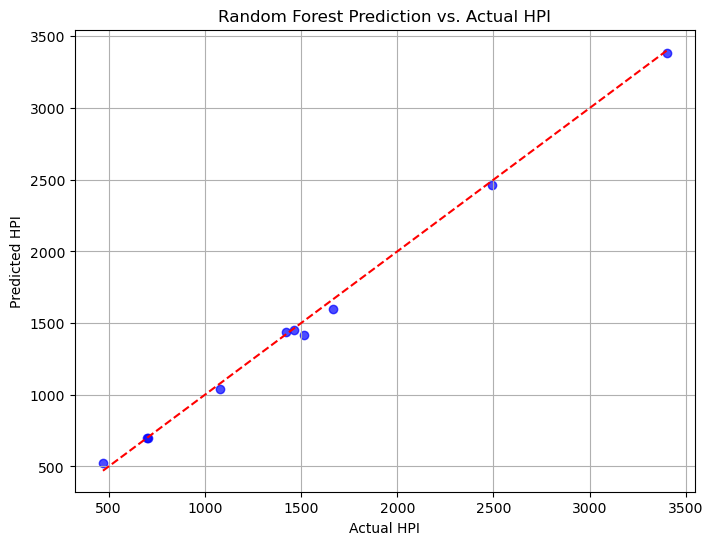

In [408]:

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_rf_train, y_rf_train)


y_rf_pred = model_rf.predict(X_rf_test)


print(len(y_rf_test), len(y_rf_pred))  # Should both be 10

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_rf_test, y_rf_pred, color='blue', alpha=0.7)
plt.plot([y_rf_test.min(), y_rf_test.max()], [y_rf_test.min(), y_rf_test.max()], color='red', linestyle='--') 
plt.xlabel("Actual HPI")
plt.ylabel("Predicted HPI")
plt.title("Random Forest Prediction vs. Actual HPI")
plt.grid(True)
plt.show()


*We can see that the model is performing well.*

In [ ]:
import pandas as pd 
actual_prediction = pd.DataFrame({'Actual HPI': y_rf_test, 'Predicted HPI': y_rf_pred})
actual_prediction.to_csv('rf_predictions.csv', index=False)

**Forecasting HPI from Random Forest**

 Predicting Total value of housing stock and Residential investment (GDP) Using Linear Regression (for forecasting HPI).

In [163]:
from sklearn.linear_model import LinearRegression
import pandas as pd


model_stock = LinearRegression()  # Total value of housing stock
model_invest = LinearRegression()  # Residential investment (GDP)


X_stock_invest = merged_df_5[['Year']]


y_stock = merged_df_5['Total value of housing stock']
y_invest = merged_df_5['Residential investment (GDP)']


model_stock.fit(X, y1)
model_invest.fit(X, y2)


future_years_stock_invest = pd.DataFrame({'Year': [2025, 2026, 2027, 2028, 2029, 2030]})


predicted_stock = model_stock.predict(future_years_linear)
predicted_investment = model_invest.predict(future_years_linear)


predicted_stock_invest = pd.DataFrame({
    'Year': future_years_stock_invest['Year'],
    'Predicted Total value of housing stock': predicted_stock,
    'Predicted Residential investment (GDP)': predicted_investment
})

print(predicted_stock_invest)


   Year  Predicted Total value of housing stock  \
0  2025                            1.467567e+06   
1  2026                            1.514857e+06   
2  2027                            1.562147e+06   
3  2028                            1.609437e+06   
4  2029                            1.656727e+06   
5  2030                            1.704018e+06   

   Predicted Residential investment (GDP)  
0                             4093.187027  
1                             4161.428420  
2                             4229.669814  
3                             4297.911208  
4                             4366.152601  
5                             4434.393995  


Analyzing Coefficient of determination and Mean Absolute Error of the liner regression model

In [173]:
from sklearn.metrics import r2_score, mean_absolute_error


y_stock_pred_train = model_stock.predict(X)
y_invest_pred_train = model_invest.predict(X)


r2_stock = r2_score(y_stock, y_stock_pred_train)
r2_investment = r2_score(y_invest, y_invest_pred_train)


mae_stock = mean_absolute_error(y_stock, y_stock_pred_train)
mae_investment = mean_absolute_error(y_invest, y_invest_pred_train)

print(f"Total value of housing stock - R2: {r2_stock:.4f}, MAE: {mae_stock:.2f}")
print(f"Residential investment (GDP) - R2: {r2_investment:.4f}, MAE: {mae_investment:.2f}")


Total value of housing stock - R2: 0.8986, MAE: 123799.98
Residential investment (GDP) - R2: 0.7477, MAE: 300.31


*Both have strong correlations, I can use these predicted numbers.*

Forecasting HPI 

In [169]:
future_data_rf = pd.DataFrame({
    'Year': [2025, 2026, 2027, 2028, 2029, 2030],
    'Total value of housing stock': [1467567, 1514857, 1562147, 1609437, 1656727, 1704018],
    'Residential investment (GDP)': [4093.18, 4161.42, 4229.66, 4297.91, 4366.15, 4434.39]
})

future_HPI_rf = model_rf.predict(future_data_rf)

future_predictions_rf = future_data_rf.copy()
future_predictions_rf['Predicted Average HPI'] = future_HPI_rf

print(future_predictions_rf)


   Year  Total value of housing stock  Residential investment (GDP)  \
0  2025                       1467567                       4093.18   
1  2026                       1514857                       4161.42   
2  2027                       1562147                       4229.66   
3  2028                       1609437                       4297.91   
4  2029                       1656727                       4366.15   
5  2030                       1704018                       4434.39   

   Predicted Average HPI  
0              3371.3400  
1              3462.5200  
2              3460.2325  
3              3460.2325  
4              3514.1025  
5              3514.1025  


#### **5-3. Simple trend modeling (Linear Regression)** 

Making a model and analyzing Coefficient of determination and Mean Absolute Error of the liner regression model

In [231]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

X_linear = merged_df_5[['Residential investment (GDP)', 'Total value of housing stock','Year']]
y_linear = merged_df_5['Average HPI']


X_linear_train, X_linear_test, y_linear_train, y_linear_test = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)


model_linear = LinearRegression()
model_linear.fit(X_linear_train, y_linear_train)


y_linear_pred = model_linear.predict(X_linear_test)


r2_linear = r2_score(y_linear_test, y_linear_pred)
mae_linear = mean_absolute_error(y_linear_test, y_linear_pred)

print("R² score:", r2_linear)
print("Mean Absolute Error (MAE):", mae_linear)


R² score: 0.9990197454334518
Mean Absolute Error (MAE): 23.415262358105792


*We can see the model indicates excellent predictive performance.*

In [112]:
y_linear_pred

array([3452.62572861, 1486.64151627, 2492.94471367, 1392.8194973 ,
        713.87946751,  716.82567204, 1435.76830442])

**Comparing Predicted and Actual HPII**

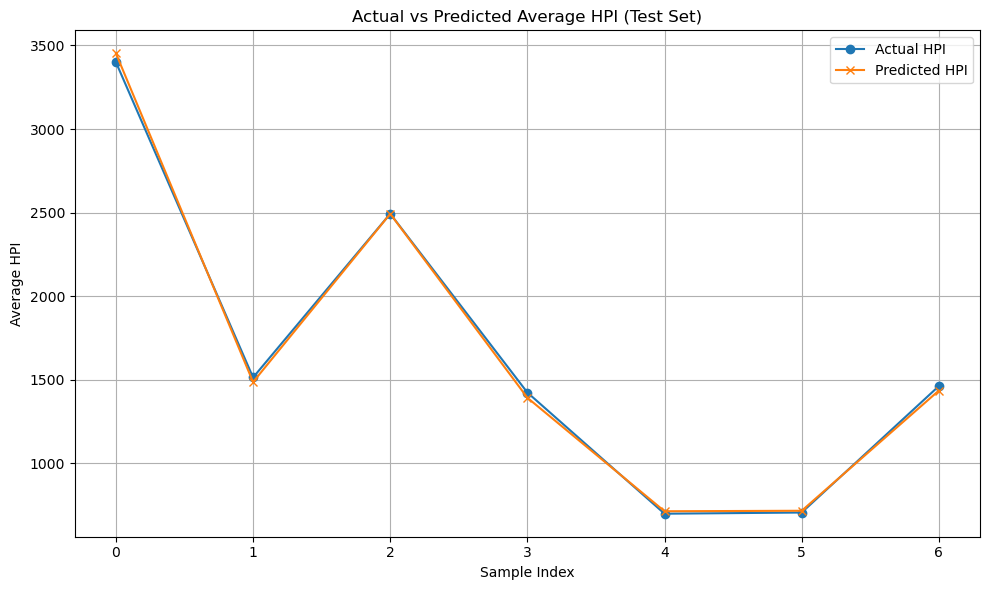

In [469]:
import matplotlib.pyplot as plt

# Actual vs Prediction
plt.figure(figsize=(10, 6))
plt.plot(y_linear_test.values, label='Actual HPI', marker='o')
plt.plot(y_linear_pred, label='Predicted HPI', marker='x')
plt.title('Actual vs Predicted Average HPI (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Average HPI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### **Making a future data set (Forecast HPI)**

In [233]:
from sklearn.linear_model import LinearRegression
import pandas as pd


future_data_linear = pd.DataFrame({
    'Year': [2025, 2026, 2027, 2028, 2029, 2030],
    'Residential investment (GDP)': [4093.18, 4161.42, 4229.66, 4297.91, 4366.15, 4434.39],
    'Total value of housing stock': [1467567, 1514857, 1562147, 1609437, 1656727, 1704018]
})


future_HPI_linear = model_linear.predict(future_data_linear[['Residential investment (GDP)', 'Total value of housing stock', 'Year']])


future_data_linear['Predicted Average HPI'] = future_HPI_linear

# Display the future data with predictions
print(future_data_linear)


   Year  Residential investment (GDP)  Total value of housing stock  \
0  2025                       4093.18                       1467567   
1  2026                       4161.42                       1514857   
2  2027                       4229.66                       1562147   
3  2028                       4297.91                       1609437   
4  2029                       4366.15                       1656727   
5  2030                       4434.39                       1704018   

   Predicted Average HPI  
0            3226.501866  
1            3322.661927  
2            3418.821989  
3            3514.982710  
4            3611.142771  
5            3707.304797  


### **6. Final Forecast & Visualization**

#### **6-1. Model Comparison Plot**

**Linear Regression vs Random Forest vs ARIMA Forecast**

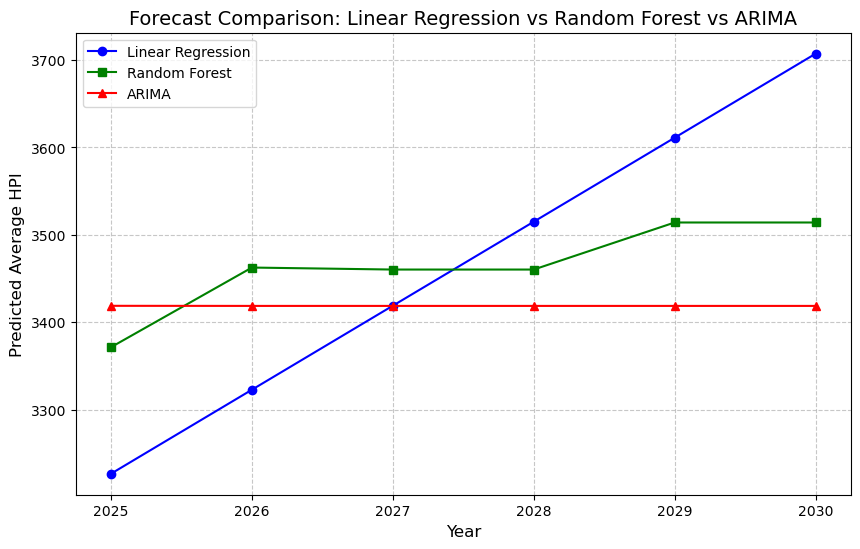

In [235]:
import matplotlib.pyplot as plt

future_years = [2025, 2026, 2027, 2028, 2029, 2030]


pred_linear = [3226.501866, 3322.661927, 3418.821989, 3514.982710, 3611.142771, 3707.304797]    # Linear Regression prediction
pred_rf = [3371.3400 , 3462.5200 , 3460.2325, 3460.2325, 3514.1025, 3514.1025]         # Random Forest prediction
pred_arima = [3418.720876, 3418.607450, 3418.609605, 3418.609564, 3418.609565, 3418.609565]      # ARIMA prediction


plt.figure(figsize=(10, 6))


plt.plot(future_years, pred_linear, marker='o', label='Linear Regression', color='blue')
plt.plot(future_years, pred_rf, marker='s', label='Random Forest', color='green')
plt.plot(future_years, pred_arima, marker='^', label='ARIMA', color='red')


plt.title('Forecast Comparison: Linear Regression vs Random Forest vs ARIMA', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Predicted Average HPI', fontsize=12)


plt.grid(True, linestyle='--', alpha=0.7)


plt.legend()


plt.show()


*After comparing multiple models, Linear Regression appeared to have the highest R² value, suggesting high prediction accuracy. However, due to the inherent nature of linear models, the predicted results were too monotonous, lacking the realism necessary for convincing forecasts.* 

*Therefore, I decided to adopt **Random Forest**. After comparing the results of the ARIMA model and Random Forest, it became clear that the predictions from Random Forest were more suitable for real-world data and demonstrated sufficient accuracy. As a result, this model was ultimately selected.*

#### **6-2. Best Model Forecast Plot (Random Forest Model)**

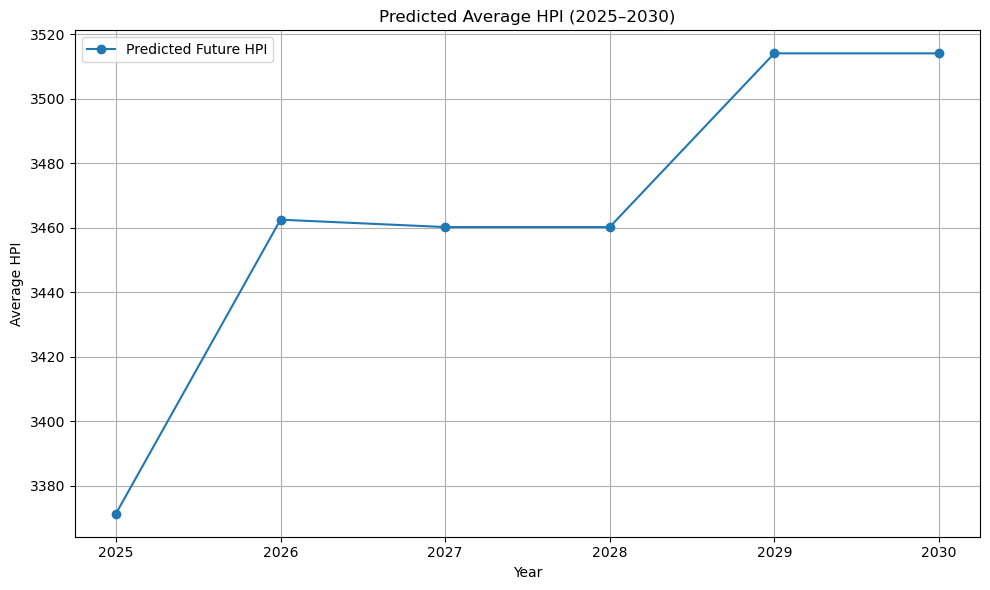

In [243]:
# グラフ表示
plt.figure(figsize=(10, 6))
plt.plot(future_predictions_rf['Year'], future_predictions_rf['Predicted Average HPI'], marker='o', label='Predicted Future HPI')
plt.title('Predicted Average HPI (2025–2030)')
plt.xlabel('Year')
plt.ylabel('Average HPI')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Converting the merged dataset and resional dataset to CSV format for Power BI analysis

In [368]:
future_predictions_rf.to_csv("future_predictions_rf.csv", index=False)

In [370]:
import os
print(os.getcwd())

C:\Users\pc\Visualization and Forecasting of Housing Prices and Population Dynamics


## **7. Conclusion and Recommendations**

In this project, I analyzed historical trends and forecasted housing prices and population dynamics in New Zealand to support urban planning, investment decisions, and housing policy development.



- **Exploratory Data Analysis (EDA)**: The analysis showed that the year is the strongest predictor of the Housing Price Index (HPI), with a correlation of 0.949. Other significant factors influencing housing prices include the total value of housing stock and residential investment (GDP). These findings suggest that the housing market in New Zealand has historically followed a predictable growth pattern driven by economic factors. However, there was a decline in housing prices after 2021, likely due to the economic impact of the COVID-19 pandemic, including rising interest rates and shifts in housing demand.

- **Regional Insights:** The analysis revealed a clear regional pattern, with Auckland consistently having the highest housing prices, while South Island Metro areas, such as Dunedin and Nelson, recorded the lowest. This insight can be valuable for regional planning and housing investment decisions.

- **Forecasting Housing Prices**: Using the Random Forest model, I forecasted housing prices from 2025 to 2030. The model predicted a moderate increase in HPI, with values stabilizing after 2027. Specifically, the forecast shows HPI rising from 3371.34 in 2025 to 3514.10 in 2030. The Random Forest model provided reliable and realistic predictions, capturing the complex relationships between housing market variables, making it a suitable choice for forecasting. 

### **Recommendations:**

- **Monitor Economic Indicators:**
Given that housing prices are closely tied to economic factors like residential investment and the total value of housing stock, it is crucial for policymakers and investors to closely monitor these indicators. Fluctuations in GDP growth and housing investment trends could signal changes in housing market dynamics.

- **Urban Planning:** The regional variations in housing prices suggest that targeted urban planning efforts are necessary to address affordability issues, especially in high-demand areas like Auckland. Policymakers could focus on increasing housing supply in these areas to balance demand and alleviate pressure on housing prices.

- **Promote Diversified Investment:**
For investors, diversification across different regions could be a strategic move. Since regional price trends vary, investing beyond Auckland into growing yet affordable areas like South Island metros may offer better long-term returns and lower risk.

- **Enhance Data-Driven Decision-Making:**
Continuous collection and analysis of housing, migration, and economic data are recommended. Integrating additional features such as interest rates, building permits, and demographic shifts could further refine predictive models and provide even more accurate forecasts.

*Thank you!*